In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from soundfile import SoundFile
import pandas as pd
from IPython.display import Audio
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm

import joblib, json, re
import noisereduce as nr

In [3]:
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [15]:
PATH = r'./kaggle/input/birdclef-2024'

## Import Data

In [16]:
df = pd.read_csv(fr'{PATH}/filtered_data_with_labels 1.csv').drop(columns = 'y')
df["filename"] = df["filename"] .str.split('/').apply(lambda x: '/'.join(x[-2:]))
df.index = df["filename"]
df.head()

,primary_label,type,latitude,longitude,rating,filename
filename,,,,,,
asbfly/XC134896.ogg,asbfly,['call'],39.2297,118.1987,5.0,asbfly/XC134896.ogg
asbfly/XC207738.ogg,asbfly,['call'],21.1697,70.6005,4.0,asbfly/XC207738.ogg
asbfly/XC209218.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209218.ogg
asbfly/XC209219.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209219.ogg
asbfly/XC267680.ogg,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,asbfly/XC267680.ogg


In [17]:
len(df.columns)

6

In [18]:
df['primary_label'].value_counts().unique()

array([308, 288, 277, 270, 268, 261, 248, 246, 245, 228, 225, 223, 211,
       202, 194, 187, 150, 148, 143, 134, 130, 122, 120, 111, 109, 107,
       105, 104, 103,  98,  95,  93,  86,  84,  82,  79,  78,  72,  70,
        68,  66,  65,  63,  61,  60,  59,  55,  54,  53,  49,  48,  47,
        45,  44,  43,  40,  39,  38,  37,  34,  33,  31,  30,  28,  27])

In [19]:
df.primary_label.value_counts().min()

27

In [20]:
df_sampled = df.groupby('primary_label').sample(n=df.primary_label.value_counts().min(), random_state=42)
df_sampled.head()

,primary_label,type,latitude,longitude,rating,filename
filename,,,,,,
asbfly/XC305518.ogg,asbfly,['call'],20.2864,100.0577,3.0,asbfly/XC305518.ogg
asbfly/XC647397.ogg,asbfly,['call'],6.8922,80.1728,5.0,asbfly/XC647397.ogg
asbfly/XC291450.ogg,asbfly,['call'],10.1653,76.5476,3.0,asbfly/XC291450.ogg
asbfly/XC596043.ogg,asbfly,['call'],17.9361,102.6217,5.0,asbfly/XC596043.ogg
asbfly/XC134896.ogg,asbfly,['call'],39.2297,118.1987,5.0,asbfly/XC134896.ogg


In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['primary_label'], random_state=42)

master = pd.read_csv(f"{PATH}/master.csv").iloc[:,1:]
master.index = master["filename"]
df_train = master.loc[df_train.index].reset_index(drop = True)
df_test = master.loc[df_test.index].reset_index(drop = True)

print(len(df_train['primary_label'].unique()), len(df_train['primary_label'].unique()))
print(len(df_train), len(df_test))

89 89
1922 481


In [22]:
print(df_train.primary_label.value_counts())
print(df_test.primary_label.value_counts())

primary_label
pursun3    22
copbar1    22
gybpri1    22
blhori1    22
commoo3    22
           ..
junowl1    21
commyn     21
houcro1    21
zitcis1    21
rewbul     21
Name: count, Length: 89, dtype: int64
primary_label
junowl1    6
grecou1    6
gyhcaf1    6
grewar3    6
whtkin2    6
          ..
eaywag1    5
bcnher     5
gloibi     5
comgre     5
pursun4    5
Name: count, Length: 89, dtype: int64


In [23]:
df_train.to_csv(f"{PATH}/df_train.csv", index = False)
df_test.to_csv(f"{PATH}/df_test.csv", index = False)

## Training

In [24]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

In [25]:
class Config:
    use_aug = False
    num_classes = len(df_train.primary_label.unique())
    batch_size = 64
    epochs = 10
    PRECISION = 16    
    PATIENCE = 8    
    seed = 42
    model = "tf_efficientnet_b0_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    train_images = PATH+"/spectrogram/"
    test_images = PATH + "/spectrogram/"
    train_path = PATH+"/df_train.csv"
    test_path = PATH+"/df_test.csv"
    
    
    SR = 32000
    DURATION = 10
    MAX_READ_SAMPLES = 5
    LR = 5e-4

In [26]:
pl.seed_everything(Config.seed, workers=True)

Seed set to 42


42

In [27]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [28]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['primary_label'])], axis=1)

In [29]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.test_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
            image = self.augmentations(image.unsqueeze(0)).squeeze()
            
        image.size()
        
        image = torch.stack([image, image, image])

        image = self.normalize(image)


        return image, torch.tensor(row[16:]).float()

In [30]:
def get_fold_dls(df_train, df_test):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = True
    )
    ds_test = BirdDataset(
        df_test, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_test = DataLoader(ds_test, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_test, ds_train, ds_test

In [31]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

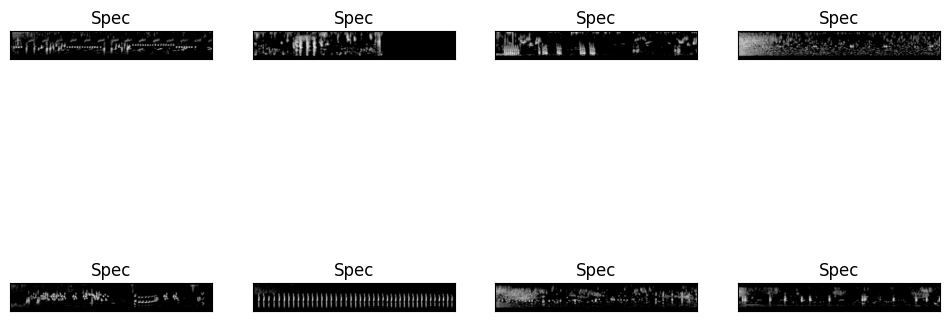

In [32]:
dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
show_batch(ds_test, 8, 2, 4)

In [33]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [34]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

In [35]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [40]:
birds = list(df_train.primary_label.unique())

In [36]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        if batch_idx == 0:
            self._logits = []
            self._targets = []
            self._val_loss = []

        self._logits.append(outputs["logits"])
        self._targets.append(outputs["targets"])
        self._val_loss.append(outputs["val_loss"])

    def on_validation_epoch_end(self):
        output_val = torch.cat(self._logits, dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat(self._targets, dim=0).cpu().detach().numpy()
        avg_loss = torch.stack(self._val_loss).mean()

        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}

In [ ]:
from pytorch_lightning.loggers import WandbLogger
import gc

def run_training():
    print(f"Running training...")
    logger = None
    
    dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= "exp2/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator="gpu"
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_test)                

    gc.collect()

In [39]:
torch.set_float32_matmul_precision('medium')

In [ ]:
run_training()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running training...
Running trainer.fit



  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | backbone      | EfficientNet      | 4.1 M  | train
1 | loss_function | BCEWithLogitsLoss | 0      | train
------------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.486    Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

epoch 0 validation loss 0.6904201507568359
epoch 0 validation C-MAP score pad 5 0.8268665518835044
epoch 0 validation C-MAP score pad 3 0.744977394726802
epoch 0 validation AP score 0.06011200054688551


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.721
Epoch 0, global step 15: 'val_loss' reached 0.72101 (best 0.72101), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 0 validation loss 0.7208530902862549
epoch 0 validation C-MAP score pad 5 0.5296111004652678
epoch 0 validation C-MAP score pad 3 0.4055151354284715
epoch 0 validation AP score 0.06453300763662564


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 30: 'val_loss' was not in top 1


epoch 0 validation loss 0.7481865882873535
epoch 0 validation C-MAP score pad 5 0.5693480895878293
epoch 0 validation C-MAP score pad 3 0.45022596627950373
epoch 0 validation AP score 0.10606593224246513


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.684
Epoch 1, global step 46: 'val_loss' reached 0.68367 (best 0.68367), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 1 validation loss 0.684235155582428
epoch 1 validation C-MAP score pad 5 0.6092961025521253
epoch 1 validation C-MAP score pad 3 0.49674084416771735
epoch 1 validation AP score 0.20646633971347228


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 61: 'val_loss' was not in top 1


epoch 1 validation loss 0.6854856610298157
epoch 1 validation C-MAP score pad 5 0.6505602910219879
epoch 1 validation C-MAP score pad 3 0.5440529800969398
epoch 1 validation AP score 0.31574748295792693


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.652
Epoch 2, global step 77: 'val_loss' reached 0.65217 (best 0.65217), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 2 validation loss 0.6553778052330017
epoch 2 validation C-MAP score pad 5 0.6973818180981282
epoch 2 validation C-MAP score pad 3 0.6019993489612169
epoch 2 validation AP score 0.3848243497659412


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.591
Epoch 2, global step 92: 'val_loss' reached 0.59081 (best 0.59081), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 2 validation loss 0.5933716297149658
epoch 2 validation C-MAP score pad 5 0.740644333097088
epoch 2 validation C-MAP score pad 3 0.6555777719880784
epoch 2 validation AP score 0.49813940020662756


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 108: 'val_loss' was not in top 1


epoch 3 validation loss 0.5969746708869934
epoch 3 validation C-MAP score pad 5 0.7616542768639012
epoch 3 validation C-MAP score pad 3 0.6838033466529129
epoch 3 validation AP score 0.5180935879785883


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.587
Epoch 3, global step 123: 'val_loss' reached 0.58654 (best 0.58654), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 3 validation loss 0.5890547037124634
epoch 3 validation C-MAP score pad 5 0.7762758527037859
epoch 3 validation C-MAP score pad 3 0.7016012310095174
epoch 3 validation AP score 0.5696154287345666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.554
Epoch 4, global step 139: 'val_loss' reached 0.55357 (best 0.55357), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 4 validation loss 0.5551153421401978
epoch 4 validation C-MAP score pad 5 0.7882853095947915
epoch 4 validation C-MAP score pad 3 0.7176096297574444
epoch 4 validation AP score 0.5869591551050639


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8db37dab60>
Traceback (most recent call last):
  File "/home/rma86/.cache/pypoetry/virtualenvs/cse6740-birdclef-1wfYQEHU-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/rma86/.cache/pypoetry/virtualenvs/cse6740-birdclef-1wfYQEHU-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 154: 'val_loss' was not in top 1


epoch 4 validation loss 0.5613210201263428
epoch 4 validation C-MAP score pad 5 0.8014140247805189
epoch 4 validation C-MAP score pad 3 0.7359484749962344
epoch 4 validation AP score 0.6070281426808287


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.528
Epoch 5, global step 170: 'val_loss' reached 0.52793 (best 0.52793), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss-v1.ckpt' as top 1


epoch 5 validation loss 0.5290766954421997
epoch 5 validation C-MAP score pad 5 0.8110685589848727
epoch 5 validation C-MAP score pad 3 0.7477493354450319
epoch 5 validation AP score 0.6274001200547707
